# Мониторинг изменений лесных угодий по спутниковым снимкам

## Проектная практика: Data Analytics + ML

Цель данной работы — продемонстрировать, как готовые предобученные модели компьютерного зрения могут применяться для мониторинга изменений лесного покрова по спутниковым изображениям.

Работа ориентирована на анализ существующих решений и их практическое применение
без обучения собственных моделей.


## Бизнес-постановка задачи

Лесные участки в пригородных и дачных зонах часто подвергаются вырубке и изменению землепользования.
Ручной контроль таких изменений требует значительных ресурсов и не всегда оперативен.

**Задача:** разработать демонстрационный прототип, который позволяет автоматически выявлять
изменения лесного покрова по спутниковым изображениям и может использоваться
как инструмент предварительного мониторинга для экологов и муниципальных служб.


## Область и тип задачи

- Область: **Computer Vision (CV)**
- Тип задачи: **Semantic Segmentation**

Семантическая сегментация позволяет классифицировать каждый пиксель изображения,
что особенно важно для анализа пространственно распределённых объектов,
таких как лесной покров.


## Выбор модели

Для демонстрации используется предобученная модель **SegFormer**, доступная на платформе Hugging Face.

Причины выбора:
- модель уже обучена на задаче сегментации;
- не требует дополнительного обучения;
- подходит для работы с изображениями сложной структуры.


In [1]:
from io import BytesIO
from PIL import Image, ImageDraw
from transformers import pipeline
import matplotlib.pyplot as plt
import requests
import torch
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Подключаем готовую модель семантической сегментации
segmenter = pipeline(
    task="image-segmentation",
    model="nvidia/segformer-b0-finetuned-ade-512-512"
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


## Подготовка демонстрационных данных

### Сценарий №1. Синтетические данные

Для наглядной демонстрации используется следующий подход:

1. Берётся одно изображение, имитирующее спутниковый снимок территории.
2. Создаётся копия изображения, в которой искусственно изменяется участок,
   имитирующий вырубку леса.

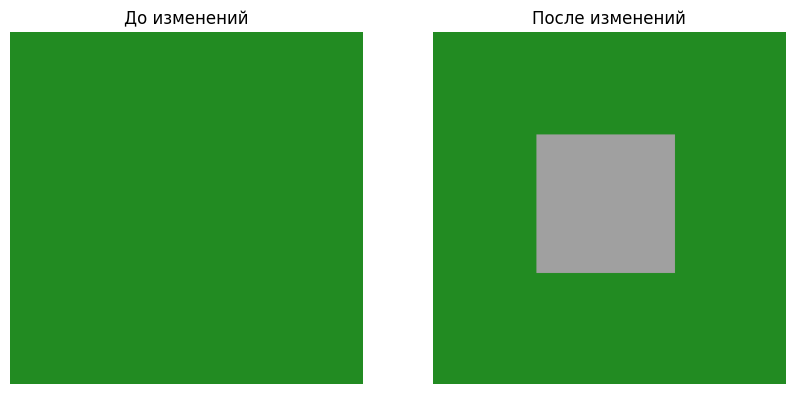

In [3]:
img1_before = Image.new("RGB", (512, 512), color=(34, 139, 34))
img1_after = img1_before.copy()

draw = ImageDraw.Draw(img1_after)
draw.rectangle([150, 150, 350, 350], fill=(160, 160, 160))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img1_before)
axes[0].set_title("До изменений")
axes[0].axis("off")

axes[1].imshow(img1_after)
axes[1].set_title("После изменений")
axes[1].axis("off")

plt.show()

### Сценарий №2. Реальный снимок

Используется реальный спутниковый снимок, содержащий визуально различимые состояния территории «до» и «после» вырубки леса.

Поскольку изображение представлено в виде одного файла, оно искусственно разделяется на две части:

1. Левая часть изображения рассматривается как состояние территории «до» изменений.
2. Правая часть изображения рассматривается как состояние территории «после» изменений.

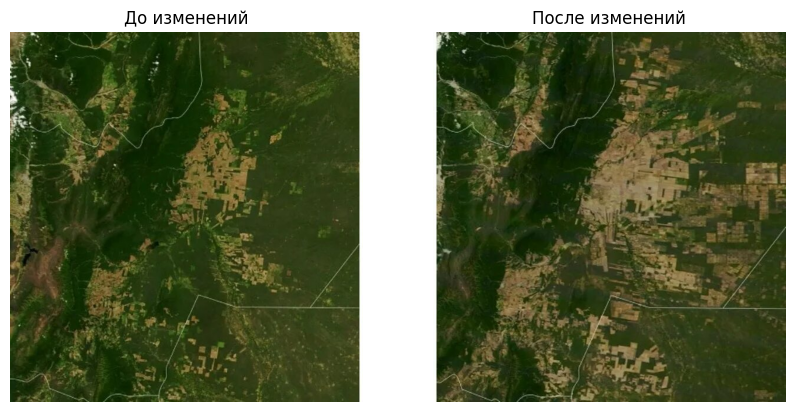

In [4]:
url = "https://avatars.mds.yandex.net/i?id=07eb950a3c1e06e5ded3da06eb3bc9e0_l-4820664-images-thumbs&n=13"

response = requests.get(url)
img = Image.open(BytesIO(response.content))

width, height = img.size

# левая половина — "до"
img2_before = img.crop((0, 0, width // 2, height))

# правая половина — "после"
img2_after = img.crop((width // 2, 0, width, height))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img2_before)
axes[0].set_title("До изменений")
axes[0].axis("off")

axes[1].imshow(img2_after)
axes[1].set_title("После изменений")
axes[1].axis("off")

plt.show()

## Применение модели

Ниже показано применение модели сегментации к изображениям до и после изменений.

Сценарий №1

In [6]:
result1_before = segmenter(img1_before)
result1_after = segmenter(img1_after)

print("Результаты сегментации:")
print(f"До изменений: модель выделила {len(result1_before)} семантический сегмент.")
print(f"После изменений: модель выделила {len(result1_after)} семантических сегмента.")

Результаты сегментации:
До изменений: модель выделила 1 семантических сегмента(ов).
После изменений: модель выделила 3 семантических сегмента(ов).


Сценарий №2

В данном сценарии модель применяется к реальному спутниковому изображению для оценки её поведения вне демонстрационного примера.

In [7]:
result2_before = segmenter(img2_before)
result2_after = segmenter(img2_after)

print("Результаты сегментации:")
print(f"До изменений: модель выделила {len(result2_before)} семантических сегмента.")
print(f"После изменений: модель выделила {len(result2_after)} семантических сегментов.")

Результаты сегментации:
До изменений: модель выделила 3 семантический сегмент.
После изменений: модель выделила 6 семантических сегмента.


## Интерпретация результатов

Модель возвращает набор сегментированных областей, каждая из которых соответствует определённому типу поверхности.

Сравнивая результаты для изображений "до" и "после", можно заметить появление новой области, которая не относится к растительности.

Это позволяет рассматривать данный участок как потенциальную зону вырубки или изменения землепользования, требующую дополнительной проверки.


## Ограничения подхода

- Используется демонстрационное изображение;
- Модель не обучалась специально под спутниковые данные высокого разрешения;
- Результаты носят предварительный характер.


## Заключение

В рамках проектной практики был реализован демонстрационный прототип, показывающий возможность использования готовых моделей машинного обучения для мониторинга изменений лесных угодий.